# 1. Исследовательский анализ данных

Загружаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [2]:
import numpy as np

Загружаем датасет labels и строим гистограмму

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


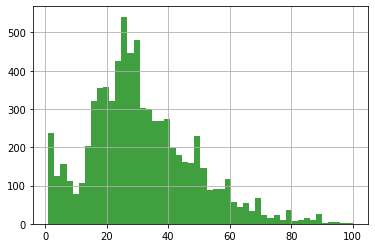

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels.head(3)
labels_g = labels.groupby('real_age').count()
n, bins, patches = plt.hist(labels['real_age'], 50,  facecolor='green', alpha=0.75)
plt.grid(True)

In [4]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Видно 2 пика на 0 и на 30 годах. Убирать пик на нуле не будем, чтобы не спугнуть тренажер.

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
datagen = ImageDataGenerator(validation_split = 0.25,rotation_range = 5, rescale=1./255, horizontal_flip = True)
train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)



Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [7]:
features_train, target_train = next(train_datagen_flow)
features_test, target_test = next(val_datagen_flow)

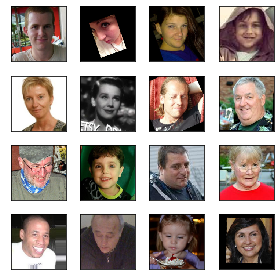

In [8]:
fig = plt.figure(figsize = (4,4))
for i in range(16):
    img = np.array(features_train[i])
    fig.add_subplot(4, 4, i+1)
    plt.imshow(img)
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видно, что датасет содержит фотографии c лицами, которые были сняты под разными углами. Для улучшения модели можно попробовать сделать небольшой поворот фотографи через rotation_range = 5, также добавить горизонтальный флип, и немного изменять масштаб лиц через width(height) shift_range, такие преобразования не изменять саму суть лица, но прилично увеличат выборку для обучения модели.

# 2. Обучение модели

``` python
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# In[2]:


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen_train = ImageDataGenerator(validation_split = 0.25, rescale = 1/ 255.0, horizontal_flip = True,rotation_range = 5,
                                width_shift_range = 0.2, height_shift_range = .2)
    train_datagen_flow = datagen_train.flow_from_dataframe(dataframe = labels, directory = '/datasets/faces/final_files/',
                                                           x_col = 'file_name', y_col = 'real_age',
                                                           target_size = (224, 224),
                                                           batch_size = 32, class_mode = 'raw',subset = 'training',
                                                           seed = 12345)
    return train_datagen_flow


# In[6]:


def load_test(path):
    labels2 = pd.read_csv('/datasets/faces/labels.csv')
    datagen_test = ImageDataGenerator(rescale = 1/ 255.0,validation_split = 0.25)
    test_datagen_flow = datagen_test.flow_from_dataframe(dataframe = labels2, directory = '/datasets/faces/final_files/',
                                                         x_col = 'file_name', y_col = 'real_age',
                                                         target_size = (224, 224),
                                                         batch_size = 32, class_mode = 'raw', subset = 'validation',
                                                         seed = 12345)
    return test_datagen_flow


# In[4]:


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    optimizer = Adam(lr= 0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer = optimizer, metrics = ['mae'])
    return model


# In[5]:


def train_model(model, train_data, test_data, batch_size = None, epochs = 5, steps_per_epoch = None, validation_steps = None):
    model.fit(train_data, verbose =2, epochs = epochs,validation_data = (test_data),
              steps_per_epoch = steps_per_epoch,batch_size = batch_size,validation_steps = validation_steps,
              shuffle = True)
    return model



```

```
Epoch 5/5
238/238 - 144s - loss: 48.0374 - mae: 5.2470 - val_loss: 54.4343 - val_mae: 5.5319
# 
```

# 3. Анализ обученной модели

1. **Данные загружены и изучены**
1. **Модель определена и обучена.**
1. **Результат МАЕ меньше 8.**

# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы